## 구글 마운트 연동

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 라이브러리 설치 / 호출

In [72]:
! pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
! pip install bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import math

import warnings
warnings.filterwarnings('ignore')
from functools import reduce

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime
from minisom import MiniSom
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

## 데이터 프레임 불러오기

In [116]:
# pkl 첨부파일 사용

df_demo = pd.read_pickle('df_demo.pkl')
df_buy = pd.read_pickle('df_buy.pkl')
df_product = pd.read_pickle('df_product.pkl')
df_store = pd.read_pickle('df_store.pkl')
df_affiliate = pd.read_pickle('df_affiliate.pkl')
df_lpay = pd.read_pickle('df_lpay.pkl')

## 필요함수 생성

### 제휴사별 데이터 프레임 생성

In [76]:
# 제휴사별 데이터 프레임
def make_table(input_affiliate):
  # Make DataFrame about input_affiliate

  target_affiliate = df_buy[df_buy['affiliate'] == input_affiliate]
  target_affi_prod = pd.merge(target_affiliate, df_product, how = 'left', on = 'product_code').drop([
      'basket', 'channel' , 'affiliate', 'store_cd', 'prod_mid_cat', 'product_code', 'prod_big_cat'
      ], axis = 1)
  
  return(target_affi_prod)

### 상품군 SOM Clustering

#### 제휴사 별 상품군 및 SOM 클러스터링 준비 데이터프레임 생성 

In [77]:
# Som Algorithm을 위한 DataFrame 생성
def som_table(target_affiliate_product):

  # Make DataFrame for clustering by SOM
  df_amt_avg = target_affiliate_product.groupby('product_name')['buy_amount'].mean().sort_values(ascending = False).reset_index()   # 상품 평균 가격
  df_amt_sd = target_affiliate_product.groupby('product_name')['buy_amount'].std().sort_values(ascending = False).reset_index().fillna(0)   # 상품 가격 편차
  df_cnt_sum = target_affiliate_product.groupby('product_name')['buy_count'].sum().sort_values(ascending = False).reset_index()
  df_cnt_uni = pd.DataFrame(target_affiliate_product.groupby(['id', 'product_name'])['buy_count'].sum().reset_index()['product_name'].value_counts()).reset_index()
  df_cnt_uni.columns = ['product_name', 'buy_count']

  dfs = [df_amt_avg, df_amt_sd, df_cnt_sum, df_cnt_uni]
  df_pd = reduce(lambda left,right: pd.merge(left,right,on='product_name'), dfs)
  df_bp = pd.DataFrame(df_pd['product_name'])  
  df_pd = df_pd.set_index('product_name')

  # Preprocessing (logarithm and normalize)
  df_pd['buy_count_x'] = np.log1p(df_pd['buy_count_x'])
  df_pd['buy_amount_x'] = np.log1p(df_pd['buy_amount_x'])
  df_pd['buy_count_y'] = np.log1p(df_pd['buy_count_y'])
  df_pd['buy_amount_y'] = np.log1p(df_pd['buy_amount_y'])

  scaler = MinMaxScaler()
  df_pd = scaler.fit_transform(df_pd)
  df_pd = pd.DataFrame(df_pd)
  df_pd.columns = list(df_pd.columns)
  df_pd.index  = list(df_pd.index)

  df_pd.columns = ['amt_avg', 'amt_sd', 'cnt_sum', 'cnt_uni']

  return(df_pd, df_bp)

#### SOM 클러스터링 및 평가


In [78]:
# SOM optimization parameter 조정

def optimization_som(input_df):

  df_pd = input_df[0]
  df_bp = input_df[1]
  #원하는 파라미터 조합 리스트화
  map_n= [n for n in range(2,3)]
  para_sigma= [np.round(sigma*0.1,2) for sigma in range(1,10)]
  para_learning_rate= [np.round(learning_rate*0.1,2) for learning_rate in range(1,10)]

  #결과 값을 담을 리스트 res 생성
  res = []
  #모든 조합에 대해 모델 생성 및 qe값 계산
  for n in map_n:
      for sigma in para_sigma:
          for lr in para_learning_rate:
              
              try:
                  #랜덤으로 초기값을 설정하는 경우
                  estimator = MiniSom(n,n,4,sigma =sigma, learning_rate = lr, topology='hexagonal',random_seed=0)
                  estimator.random_weights_init(df_pd.values)
                  estimator.train(df_pd.values,1000,random_order=True)
                  qe = estimator.quantization_error(df_pd.values)
                  winner_coordinates = np.array([estimator.winner(x) for x in df_pd.values]).T
                  cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                  
                  res.append([str(n)+'x'+str(n),sigma,lr,'random_init',qe,len(np.unique(cluster_index))])

                  #pca로 초기값을 설정하는 경우
                  estimator = MiniSom(n,n,4,sigma =sigma, learning_rate = lr,topology='hexagonal', random_seed=0)
                  estimator.pca_weights_init(df_pd.values)
                  estimator.train(df_pd.values,1000,random_order=True)
                  qe = estimator.quantization_error(df_pd.values)
                  winner_coordinates = np.array([estimator.winner(x) for x in df_pd.values]).T
                  cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                  
                  res.append([str(n)+'x'+str(n),sigma,lr,'pca_init',qe,len(np.unique(cluster_index))])
                  
              except ValueError as e:
                  print(e)
              
  #결과 데이터프레임 생성 및 sorting 
  df_res = pd.DataFrame(res,columns=['map_size','sigma','learning_rate','init_method','qe','n_cluster']) 
  df_res.sort_values(by=['qe'],ascending=True,inplace=True,ignore_index=True)

  return(df_res)

In [79]:
# SOM Clustering 시각화

def evaluate_som(input_df, best_sigma, best_learning_rate, best_method):

  df_pd = input_df[0]
  df_bp = input_df[1]
  
  #Evaluation SOM
  som = MiniSom(2,2,4,sigma=best_sigma,learning_rate=best_learning_rate,
                   topology='hexagonal', random_seed=0)
  
  #초기값설정
  if best_method == 'random_init': 
    som.random_weights_init(df_pd.values)
  else:
    som.random_weights_init(df_pd.values)

  som.train(df_pd.values,1000,random_order=True)
  winner_coordinates = np.array([som.winner(x) for x in df_pd.values]).T
  cluster_index = np.ravel_multi_index(winner_coordinates,(2,2))  

  #평가
  print('================================================')
  print('Quantization Error:', som.quantization_error(df_pd.values))
  print('================================================')

  xx, yy = som.get_euclidean_coordinates()
  umatrix = som.distance_map()
  weights = som.get_weights()

  f = plt.figure(figsize=(10,10))
  ax = f.add_subplot(111)
  ax.set_aspect('equal')

  # iteratively add hexagons
  # plotting the distance map as background
  # 해당 셀과 다른 이웃들 간 거리를 표현, 밝을수록 가깝고, 어두울수록 멀다
  for i in range(weights.shape[0]):
      for j in range(weights.shape[1]):
          wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
          hex = RegularPolygon((xx[(i, j)], wy), 
                              numVertices=6, 
                              radius=.95 / np.sqrt(3),
                              facecolor=cm.Blues(umatrix[i, j]), 
                              alpha=.4, 
                              edgecolor='gray')
          plot = ax.add_patch(hex)

  #output노드에 해당하는 클러스터 종류 및 밀도 확인         
  cnt=[]
  for c in np.unique(cluster_index):
          x_= [som.convert_map_to_euclidean(som.winner(x))[0] + (2*np.random.rand(1)[0]-1)*0.4 for x in df_pd.values[cluster_index==c]]
          y_= [som.convert_map_to_euclidean(som.winner(x))[1] + (2*np.random.rand(1)[0]-1)*0.4 for x in df_pd.values[cluster_index==c]]
          y_= [(i* 2 / np.sqrt(3) * 3 / 4) for i in y_]
      
          plot = sns.scatterplot( x = x_,  y= y_ ,label='cluster='+str(c),alpha=.7)
          
          #클러스터에 속한 데이터 개수 데이터프레임으로 출력
          cnt.append([c,len(x_)])

  #클러스터별 개수를 표 형태로 출력 
  df_cnt = pd.DataFrame(cnt,columns=['cluster이름','개수'])
  print('[ Hexagon Plot for Clustering ]')
  #x축,y축 간격 설정 
  xrange = np.arange(weights.shape[0])
  yrange = np.arange(weights.shape[1])
  plot = plt.xticks(xrange-.5, xrange)
  plot = plt.yticks(yrange * 2 / np.sqrt(3) * 3 / 4, yrange)

#### SOM Clustering Example

In [80]:
sample_affiliate = 'A01'

buy_by_affiliate = make_table(input_affiliate = sample_affiliate)
df_som = som_table(target_affiliate_product = buy_by_affiliate)

opt_som = optimization_som(input_df = df_som)
best_sigma = opt_som.sigma[0]
best_learning_rate = opt_som.learning_rate[0]
best_method = opt_som.init_method[0]

opt_som

,map_size,sigma,learning_rate,init_method,qe,n_cluster
0,2x2,0.8,0.7,pca_init,0.200603,4
1,2x2,0.7,0.7,pca_init,0.200622,4
2,2x2,0.6,0.7,pca_init,0.200625,4
3,2x2,0.5,0.7,pca_init,0.200625,4
4,2x2,0.9,0.7,pca_init,0.200786,4
...,...,...,...,...,...,...
157,2x2,0.2,0.8,pca_init,0.380551,1
158,2x2,0.3,0.8,pca_init,0.380551,1
159,2x2,0.1,0.9,pca_init,0.383332,1
160,2x2,0.3,0.9,pca_init,0.383332,1


Quantization Error: 0.201786767456216
[ Hexagon Plot for Clustering ]


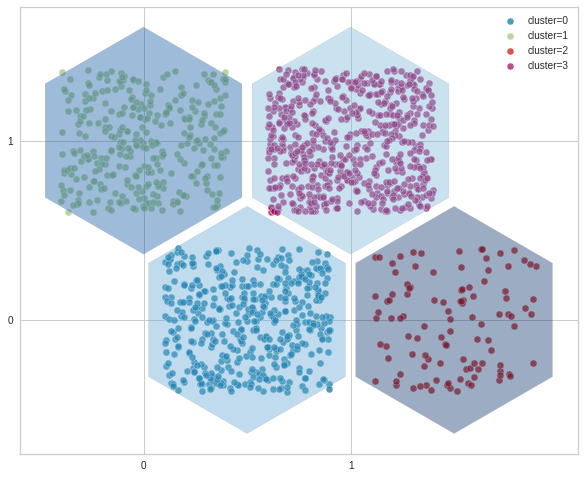

In [81]:
evaluate_som(df_som, best_sigma, best_learning_rate, best_method)

#### 최종 SOM Cluster 모델링

In [82]:
def som_cluster(input_df, best_sigma, best_learning_rate, best_method):

  df_pd = input_df[0]
  df_bp = input_df[1]

  som = MiniSom(2,2,4,
                sigma =best_sigma, learning_rate = best_learning_rate,
                topology='hexagonal', random_seed=0)
  
  #초기값설정
  if best_method == 'random_init': 
    som.random_weights_init(df_pd.values)
  else:
    som.random_weights_init(df_pd.values)
    
  som.train(df_pd.values,1000,random_order=True)
  winner_coordinates = np.array([som.winner(x) for x in df_pd.values]).T
  cluster_index = np.ravel_multi_index(winner_coordinates,(2,2))

  
  return(cluster_index)

### 분석 데이터 프레임 생성

#### Quantile Transformation

In [83]:
def Quantile_Trans(input_df):
  
  cols = input_df.columns
  for cs in cols:
    input_list = input_df[cs]

    Q5 = np.quantile(input_list, 0.05)
    Q95 = np.quantile(input_list, 0.95)

    output_list = []
    for values in input_list:
      if  values < Q5:
        delta = Q5 - values
        winsorizing = 0.01 * np.log(1+np.log(1+delta))
        new_values = 0 - winsorizing
      elif values > Q95:
        delta = values - Q95
        winsorizing = 0.01 * np.log(1+np.log(1+delta))
        new_values = 1 + winsorizing
      else:
        new_values = (values - Q5) / (Q95 - Q5)
      
      output_list.append(new_values)
    input_df[cs] = output_list
    
  return(input_df)

#### 고객 프로파일링 수행 함수

In [84]:
### 고객 프로파일링 만드는 함수 ###
def create_id_profiling(df_buy, mid_list, name_list):
  df_buy_prod = pd.merge(df_buy, df_product, how = 'left', on = 'product_code').drop(['basket', 'affiliate', 'buy_date', 'buy_time'], axis = 1)
  df_buy_prod.loc[df_buy_prod['store_cd'] != df_buy_prod['store_cd'],'store_cd'] = 'online'
  
  df_demo_buy_prod = pd.merge(df_demo, df_buy_prod, how = 'right', on = 'id')
  
  df_final = pd.merge(df_demo_buy_prod, df_store, how = 'left', on = 'store_cd').dropna(subset = ['id']).drop(['affiliate'], axis = 1)
  
  for i in mid_list:
    df_final = mid_col_change(df_final, i)
    
  for i in name_list:
    df_final = name_col_change(df_final, i)
    
  df = df_final.drop(['product_name', 'prod_mid_cat'], axis = 1)
  
  prod_sum = df.groupby('prod_big_cat').sum()['buy_count']
  
  # 상품군별 각 고객의 구매 비율 (열의 합 : 1)
  grouped_by_pd = df['buy_count'].groupby([df['id'], df['prod_big_cat']]).sum() / df.groupby('prod_big_cat').sum()['buy_count'] * 10000
  grouped_by_pd = grouped_by_pd.unstack().fillna(0)
  
  grouped_by_pd = Quantile_Trans(grouped_by_pd)
  
  grouped_by_pd = grouped_by_pd.reset_index()
  df_profile_by_pd = pd.merge(df_demo, grouped_by_pd, how = 'right', on = 'id')

  # 고객별 각 상품군의 구매 비율 (행의 합 : 1)
  grouped_by_id = df['buy_count'].groupby([df['id'], df['prod_big_cat']]).sum() / df.groupby('id').sum()['buy_count']
  grouped_by_id = grouped_by_id.unstack().fillna(0).reset_index()
  df_profile_by_id = pd.merge(df_demo, grouped_by_id, how = 'right', on = 'id')

  # 고객별 상품의 구매 비율 x 상품별 고객의 구매 비율
  df_profile = pd.concat([df_profile_by_id.iloc[:,0:4], df_profile_by_id.iloc[:,4:] * df_profile_by_pd.iloc[:,4:]], axis=1)
  df_profile
  # 여기에 quantile regression도 들어가야할 듯!

  return(df_profile)

In [85]:
### 상품 대분류를 중분류로 대체하는 함수 ###
def mid_col_change(df, value):
  df.loc[df.prod_mid_cat == value, "prod_big_cat"] = value
  return(df)

### 상품 대분류를 상품명으로 대체하는 함수 ###
def name_col_change(df, value):
  df.loc[df.product_name == value, "prod_big_cat"] = value
  return(df)

#### RFM 생성 함수

In [86]:
def make_class_RF(dataframe, target_columns, types):
    
    # class criteria for type = 'R'
    if types == 'R':
        dfs = dataframe[target_columns].groupby(dataframe['id']).max()
        
        c1 = np.quantile(dfs.unique(), 0.5)
        c2 = np.quantile(dfs.unique(), 0.75)
        c3 = np.quantile(dfs.unique(), 0.875)
        c4 = np.quantile(dfs.unique(), 0.955)
    
    # class criteria for type = 'F'
    elif types == 'F':
        dfs = dataframe[target_columns].groupby(dataframe['id']).size()
        dfsu = dfs.unique()
 
        c1 = 1                        
        c2 = np.median(dfsu[dfsu > c1])   
        c3 = np.median(dfsu[dfsu > c2])   
        c4 = np.median(dfsu[dfsu > c3])   
       
       # Threshold : (<1, <20, <45, <81, otherwise)
       # Number    : (1783, 9235, 4759, 2326, 2219)                            
    
    # Unavailable types
    else:
        print('Types must be in [R, F]')
    # class assignment
    C = []
    for i in dfs:
        if i <= c1:
            C.append(1)
        elif i > c1 and i <= c2:
            C.append(2)
        elif i > c2 and i <= c3:
            C.append(3)
        elif i > c3 and i <= c4:
            C.append(4)
        else:
            C.append(5)
        
    return(C)

def make_class_M(dataframe):

    sorted_amount = sorted(dataframe['buy_amount'].groupby(dataframe['id']).sum())
    cumsum_sorted_amount = itertools.accumulate(sorted_amount)

    cumsum = []
    for k in cumsum_sorted_amount:
        cumsum.append(k)

    ids = dataframe['buy_amount'].groupby(dataframe['id']).sum().reset_index().id
    sorted_by_cumsum = sorted(list(zip(ids, dataframe['buy_amount'].groupby(dataframe['id']).sum())), key=lambda x: x[1])

    sorted_by_cumsum =  pd.DataFrame(sorted_by_cumsum, columns = ['id', 'sum_amount'])
    sorted_by_cumsum['cumsum_amount'] = cumsum

    M = []
    alpha = dataframe.buy_amount.sum()/5
    for cumsums in sorted_by_cumsum.cumsum_amount:
        if cumsums < alpha:
            M.append(1)
        elif cumsums >= alpha and cumsums < 2*alpha:
            M.append(2)
        elif cumsums >= 2*alpha and cumsums < 3*alpha:
            M.append(3)
        elif cumsums >= 3*alpha and cumsums < 4*alpha:
            M.append(4)
        else:
            M.append(5)

    sorted_by_cumsum['M'] = M
    sorted_by_cumsum = sorted_by_cumsum.drop(['sum_amount', 'cumsum_amount'], 1)
    return(sorted_by_cumsum)

In [87]:
def RFM_print(input_RFM):

  if input_RFM == [1, 1, 1]:
    print('Input customer : 서비스 충성도가 높은 VIP')
  elif input_RFM == [1, 1, 0]:
    print('Input customer : 구매 빈도가 높은 잠재 VIP')
  elif input_RFM == [1, 0, 1]:
    print('Input customer : 구매 액수가 큰 잠재 VIP')

  elif input_RFM == [1, 0, 0]:
    print('Input customer : 신규 고객')

  elif input_RFM == [0, 1, 1]:
    print('Input customer : 떠나간 VIP')
  elif input_RFM == [0, 0, 1]:
    print('Input customer : 떠나간 잠재 VIP')
  elif input_RFM == [0, 1, 0]:
    print('Input customer : 떠나간 잠재 VIP')
  else:
    print('Input customer : 구매매 이력이 거의 없는 고객')

#### 지향 테이블 만들기

##### 고객별 지향 점수 및 순위 계산 함수

In [88]:
def character_table(input_affiliate):

  if input_affiliate == 'A01':
    
    # 제휴사별 분류1 A01
    # A01 - 상품군1: '금융/보험서비스',  '기타상품'이 없음
    가구 = ['가구', '계절가전', '냉장/세탁가전', '생활/주방가전', '세제/위생', '속옷/양말/홈웨어', '식기/조리기구', 'TV', '주방잡화', '청소/세탁/욕실용품', '침구/수예']
    요리및후식 = ['건해산물', '과일', '수산물', '양곡', '유제품', '음료', '조미료', '채소', '축산물', '커피/차']
    자녀 = ['유아동가구', '사무용/학생용가구', '유아동속옷', '유아동양말류', '유아동스포츠화', '유아동일반스포츠의류', '유아동식기', '남아완구', '여아완구', '유아동의류', '유아식품', '출산/육아용품', '유아동침구', '유아동화']
    건강 = ['건강식품', '기능성음료', '구강케어', '헬스/피트니스']
    DIY = ['공구/안전용품', '파티/팬시용품', '인테리어/조명', '자동차용품']
    고급 = ['골프', '랍스터', '킹크랩', '남성골프의류', '여성골프의류', '국산소고기', '한우선물세트', '보석', '여성특수소재의류']
    간편 = ['과자', '냉동식품', '냉장식품', '대용식', '병통조림', '생활서비스', '조리식품', '테넌트/음식점']
    외모 = ['남성의류', '여성의류', '패션잡화', '퍼스널케어', '화장품/뷰티케어']
    스트레스해소 = ['담배', '주류']
    취미 = ['서적/음반/악기', '영상/음향가전', '완구', '원예', '원예용품']
    반려동물 = ['고양이용품', '기타애완동물', '동물병원', '애견용품']
    IT = ['모바일', '컴퓨터']
    교육 = ['문구/사무용품', '서적', '교육완구']
    아웃도어 = ['스포츠패션', '시즌스포츠', '아웃도어/레저', '렌탈서비스', '캠핑', '여행/레저서비스', '여행용가방류']
    기타 = ['건강용품', '기타(비상품)', '상품권', '비식품테넌트']

  elif input_affiliate == 'A02':

    # 제휴사별 분류1 A02
    # A02 - '냉장/세탁가전', 'TV', '렌탈서비스', '금융/보험서비스'가 없음

    가구 = ['가구', '계절가전',  '생활/주방가전', '세제/위생', '속옷/양말/홈웨어', '식기/조리기구',  '주방잡화', '청소/세탁/욕실용품', '침구/수예']
    요리및후식 = ['건해산물', '과일', '수산물', '양곡', '유제품', '음료', '조미료', '채소', '축산물', '커피/차']
    자녀 = ['유아동가구', '사무용/학생용가구', '유아동속옷', '유아동양말류', '유아동스포츠화', '유아동일반스포츠의류', '유아동식기', '남아완구', '여아완구', '유아동의류', '유아식품', '출산/육아용품', '유아동침구', '유아동화']
    건강 = ['건강식품', '기능성음료', '구강케어', '헬스/피트니스']
    DIY = ['공구/안전용품', '파티/팬시용품', '인테리어/조명', '자동차용품']
    고급 = ['골프', '랍스터', '킹크랩', '남성골프의류', '여성골프의류', '국산소고기', '한우선물세트', '보석', '여성특수소재의류']
    간편 = ['과자', '냉동식품', '냉장식품', '대용식', '병통조림', '생활서비스', '조리식품', '테넌트/음식점']
    외모 = ['남성의류', '여성의류', '패션잡화', '퍼스널케어', '화장품/뷰티케어']
    스트레스해소 = ['담배', '주류']
    취미 = ['서적/음반/악기', '영상/음향가전', '완구', '원예', '원예용품']
    반려동물 = ['고양이용품', '기타애완동물', '동물병원', '애견용품']
    IT = ['모바일', '컴퓨터']
    교육 = ['문구/사무용품', '서적', '교육완구']
    아웃도어 = ['스포츠패션', '시즌스포츠', '아웃도어/레저',  '캠핑', '여행/레저서비스', '여행용가방류']
    기타 = ['건강용품', '기타(비상품)', '기타상품', '상품권', '비식품테넌트']

  elif input_affiliate == 'A03':

    # 제휴사별 분류
    # A03 - '냉장/세탁가전', 'TV'
    #       '유아동가구', '사무용/학생용가구', '유아동속옷', '유아동양말류', '유아동스포츠화', '유아동일반스포츠의류', '남아완구', '유아동의류', '유아동침구'
    #       '헬스/피트니스', '생활서비스', '여성의류', '서적/음반/악기', '영상/음향가전', '완구', '기타애완동물', '동물병원'
    #        '스포츠패션', '시즌스포츠','렌탈서비스','여행/레저서비스', '여행용가방류', '금융/보험서비스','기타상품', '상품권'이 없음

    가구 = ['가구', '계절가전',  '생활/주방가전', '세제/위생', '속옷/양말/홈웨어', '식기/조리기구', '주방잡화', '청소/세탁/욕실용품', '침구/수예']
    요리및후식 = ['건해산물', '과일', '수산물', '양곡', '유제품', '음료', '조미료', '채소', '축산물', '커피/차']
    자녀 = ['유아동식기', '여아완구', '유아식품', '출산/육아용품', '유아동화']
    건강 = ['건강식품', '기능성음료', '구강케어']
    DIY = ['공구/안전용품', '파티/팬시용품', '인테리어/조명', '자동차용품']
    고급 = ['골프', '랍스터', '킹크랩', '남성골프의류', '여성골프의류', '국산소고기', '한우선물세트', '보석', '여성특수소재의류']
    간편 = ['과자', '냉동식품', '냉장식품', '대용식', '병통조림', '조리식품', '테넌트/음식점']
    외모 = ['남성의류', '패션잡화', '퍼스널케어', '화장품/뷰티케어']
    스트레스해소 = ['담배', '주류']
    취미 = ['원예', '원예용품']
    반려동물 = ['고양이용품', '애견용품']
    IT = ['모바일', '컴퓨터']
    교육 = ['문구/사무용품', '서적', '교육완구']
    아웃도어 = [ '아웃도어/레저', '캠핑']
    기타 = ['건강용품', '기타(비상품)', '비식품테넌트']

  elif input_affiliate == 'A04':

    # 제휴사별 분류
    # A04 = '가구', '냉장/세탁가전', '식기/조리기구', 'TV', '침구/수예'
    # '유아동가구', '사무용/학생용가구', '유아동속옷', '유아동양말류', '유아동스포츠화', '유아동일반스포츠의류', '유아동식기', '유아동의류', '유아식품', '유아동침구', '유아동화'
    # '헬스/피트니스', '테넌트/음식점', '여성의류', '서적/음반/악기', '영상/음향가전' '원예용품', '기타애완동물', '동물병원'
    # '렌탈서비스', '여행/레저서비스', '여행용가방류', '금융/보험서비스', '기타상품', '비식품테넌트'

    가구 = ['계절가전', '생활/주방가전', '세제/위생', '속옷/양말/홈웨어', '주방잡화', '청소/세탁/욕실용품']
    요리및후식 = ['건해산물', '과일', '수산물', '양곡', '유제품', '음료', '조미료', '채소', '축산물', '커피/차']
    자녀 = ['남아완구', '여아완구', '출산/육아용품']
    건강 = ['건강식품', '기능성음료', '구강케어']
    DIY = ['공구/안전용품', '파티/팬시용품', '인테리어/조명', '자동차용품']
    고급 = ['골프', '랍스터', '킹크랩', '남성골프의류', '여성골프의류', '국산소고기', '한우선물세트', '보석', '여성특수소재의류']
    간편 = ['과자', '냉동식품', '냉장식품', '대용식', '병통조림', '생활서비스', '조리식품']
    외모 = ['남성의류', '패션잡화', '퍼스널케어', '화장품/뷰티케어']
    스트레스해소 = ['담배', '주류']
    취미 = ['완구', '원예']
    반려동물 = ['고양이용품', '애견용품']
    IT = ['모바일', '컴퓨터']
    교육 = ['문구/사무용품', '서적', '교육완구']
    아웃도어 = ['스포츠패션', '시즌스포츠', '아웃도어/레저', '캠핑']
    기타 = ['건강용품', '기타(비상품)', '상품권']

  elif input_affiliate == 'A05':

    # 제휴사별 분류
    # A05 - '속옷/양말/홈웨어', '건해산물', '과일', '수산물', '음료', '채소', '축산물', '유아동가구', '유아동속옷', '유아동양말류', '유아동스포츠화', '유아동일반스포츠의류', '유아동식기', '유아동의류', '유아동침구', '유아동화'
    # '건강식품', '기능성음료', '파티/팬시용품', '냉동식품', '냉장식품', '대용식', '병통조림', '생활서비스', '조리식품', '테넌트/음식점'
    # '남성의류', '여성의류', '서적/음반/악기', '주류', '원예', '고양이용품', '기타애완동물', '동물병원', '서적', '스포츠패션', '시즌스포츠', '여행/레저서비스'
    # '기타상품', '상품권', '비식품테넌트'

    가구 = ['가구', '계절가전', '냉장/세탁가전', '생활/주방가전', '세제/위생', '식기/조리기구', 'TV', '주방잡화', '청소/세탁/욕실용품', '침구/수예']
    요리및후식 = ['양곡', '유제품', '조미료', '커피/차']
    자녀 = ['사무용/학생용가구','남아완구', '여아완구', '유아식품', '출산/육아용품' ]
    건강 = ['구강케어', '헬스/피트니스']
    DIY = ['공구/안전용품', '인테리어/조명', '자동차용품']
    고급 = ['골프', '랍스터', '킹크랩', '남성골프의류', '여성골프의류', '국산소고기', '한우선물세트', '보석', '여성특수소재의류']
    간편 = ['과자']
    외모 = ['패션잡화', '퍼스널케어', '화장품/뷰티케어']
    스트레스해소 = ['담배']
    취미 = ['영상/음향가전', '완구', '원예용품']
    반려동물 = ['애견용품']
    IT = ['모바일', '컴퓨터']
    교육 = ['문구/사무용품', '교육완구']
    아웃도어 = ['아웃도어/레저', '렌탈서비스', '캠핑', '여행용가방류']
    기타 = ['건강용품', '금융/보험서비스', '기타(비상품)']

  elif input_affiliate == 'A06':

    # 제휴사별 분류
    # A06 - '유아동스포츠화', '담배', '동물병원' '금융/보험서비스', '기타상품', '비식품테넌트'

    가구 = ['가구', '계절가전', '냉장/세탁가전', '생활/주방가전', '세제/위생', '속옷/양말/홈웨어', '식기/조리기구', 'TV', '주방잡화', '청소/세탁/욕실용품', '침구/수예']
    요리및후식 = ['건해산물', '과일', '수산물', '양곡', '유제품', '음료', '조미료', '채소', '축산물', '커피/차']
    자녀 = ['유아동가구', '사무용/학생용가구', '유아동속옷', '유아동양말류', '유아동일반스포츠의류', '유아동식기', '남아완구', '여아완구', '유아동의류', '유아식품', '출산/육아용품', '유아동침구', '유아동화']
    건강 = ['건강식품', '기능성음료', '구강케어', '헬스/피트니스']
    DIY = ['공구/안전용품', '파티/팬시용품', '인테리어/조명', '자동차용품']
    고급 = ['골프', '랍스터', '킹크랩', '남성골프의류', '여성골프의류', '국산소고기', '한우선물세트', '보석', '여성특수소재의류']
    간편 = ['과자', '냉동식품', '냉장식품', '대용식', '병통조림', '생활서비스', '조리식품', '테넌트/음식점']
    외모 = ['남성의류', '여성의류', '패션잡화', '퍼스널케어', '화장품/뷰티케어']
    스트레스해소 = ['주류']
    취미 = ['서적/음반/악기', '영상/음향가전', '완구', '원예', '원예용품']
    반려동물 = ['고양이용품', '기타애완동물', '애견용품']
    IT = ['모바일', '컴퓨터']
    교육 = ['문구/사무용품', '서적', '교육완구']
    아웃도어 = ['스포츠패션', '시즌스포츠', '아웃도어/레저', '렌탈서비스', '캠핑', '여행/레저서비스', '여행용가방류']
    기타 = ['건강용품', '기타(비상품)', '상품권']
    
  mid_list = ['TV',            
              '유아동가구', '사무용/학생용가구', '유아동속옷', '유아동양말류', '유아동스포츠화', '유아동일반스포츠의류', '유아동식기', '남아완구', '여아완구', '유아동침구', '유아동화',
              '기능성음료', '구강케어',
              '파티/팬시용품',
              '골프', '남성골프의류', '여성골프의류', '국산소고기', '보석', '여성특수소재의류',
              '생활서비스',
              '원예', '원예용품',
              '고양이용품', '기타애완동물', '동물병원', '애견용품',
              '서적', '교육완구',
              '렌탈서비스', '캠핑', '여행용가방류',
              '비식품테넌트']

  name_list = ['랍스터', '킹크랩', '한우선물세트']

  df_a = df_buy[df_buy.affiliate == input_affiliate]
  id_profile = create_id_profiling(df_a, mid_list, name_list)  

  id_feature_a = id_profile.copy()
  character_name = ['가사지향',	'요리및후식지향',	'자녀지향',	'건강지향',	'DIY지향',	'간편지향',	'외모지향',	'스트레스해소지향',	'취미지향',	'반려동물지향',	'IT지향',	'교육지향',	'아웃도어지향',	'기타지향']
  character_value = [가구, 요리및후식, 자녀, 건강, DIY, 간편, 외모, 스트레스해소, 취미, 반려동물, IT, 교육, 아웃도어, 기타]

  for i, j in zip(character_name, character_value):
    id_feature_a[i] = id_feature_a[j].sum(axis=1)

  id_feature_a.drop(columns = list(id_profile.columns[4:]), inplace = True)

  list_rank1 = []
  list_rank2 = []
  list_rank3 = []

  column = id_feature_a.columns[4:]
  for i in range(0,id_feature_a.shape[0]):

    lists = list(zip(column, id_feature_a.iloc[i:i+1,4:].values.tolist()[0]))
    sorted_list = sorted(lists, key=lambda x: x[1], reverse = True)
    rank1 = sorted_list[0][0]
    rank2 = sorted_list[1][0]
    rank3 = sorted_list[2][0]

    list_rank1.append(rank1)
    list_rank2.append(rank2)
    list_rank3.append(rank3)

  id_feature_a['rank1'] = list_rank1
  id_feature_a['rank2'] = list_rank2
  id_feature_a['rank3'] = list_rank3

  #df_rank = pd.DataFrame([id_feature_a.id, list_rank1, list_rank2, list_rank3]).T
  #df_rank.columns = ['id', 'rank1', 'rank2', 'rank3']
  id_feature_a = id_feature_a.fillna(0)

  return(id_feature_a)

#### Sample 데이터를 통한 검증

In [89]:
input_affiliate = 'A01'

mid_list = ['TV',            
            '유아동가구', '사무용/학생용가구', '유아동속옷', '유아동양말류', '유아동스포츠화', '유아동일반스포츠의류', '유아동식기', '남아완구', '여아완구', '유아동침구', '유아동화',
            '기능성음료', '구강케어',
            '파티/팬시용품',
            '골프', '남성골프의류', '여성골프의류', '국산소고기', '보석', '여성특수소재의류',
            '생활서비스',
            '원예', '원예용품',
            '고양이용품', '기타애완동물', '동물병원', '애견용품',
            '서적', '교육완구',
            '렌탈서비스', '캠핑', '여행용가방류',
            '비식품테넌트']

name_list = ['랍스터', '킹크랩', '한우선물세트']


가사 = ['가구', '계절가전', '냉장/세탁가전', '생활/주방가전', '세제/위생', '속옷/양말/홈웨어', '식기/조리기구', 'TV', '주방잡화', '청소/세탁/욕실용품', '침구/수예']
요리및후식 = ['건해산물', '과일', '수산물', '양곡', '유제품', '음료', '조미료', '채소', '축산물', '커피/차']
자녀 = ['유아동가구', '사무용/학생용가구', '유아동속옷', '유아동양말류', '유아동스포츠화', '유아동일반스포츠의류', '유아동식기', '남아완구', '여아완구', '유아동의류', '유아식품', '출산/육아용품', '유아동침구', '유아동화']
건강 = ['건강식품', '기능성음료', '구강케어', '헬스/피트니스']
DIY = ['공구/안전용품', '파티/팬시용품', '인테리어/조명', '자동차용품']
고급 = ['골프', '랍스터', '킹크랩', '남성골프의류', '여성골프의류', '국산소고기', '한우선물세트', '보석', '여성특수소재의류']
간편 = ['과자', '냉동식품', '냉장식품', '대용식', '병통조림', '생활서비스', '조리식품', '테넌트/음식점']
외모 = ['남성의류', '여성의류', '패션잡화', '퍼스널케어', '화장품/뷰티케어']
스트레스해소 = ['담배', '주류']
취미 = ['서적/음반/악기', '영상/음향가전', '완구', '원예', '원예용품']
반려동물 = ['고양이용품', '기타애완동물', '동물병원', '애견용품']
IT = ['모바일', '컴퓨터']
교육 = ['문구/사무용품', '서적', '교육완구']
아웃도어 = ['스포츠패션', '시즌스포츠', '아웃도어/레저', '렌탈서비스', '캠핑', '여행/레저서비스', '여행용가방류']
기타 = ['건강용품', '기타(비상품)', '상품권', '비식품테넌트']



df_a = df_buy[df_buy.affiliate == input_affiliate]
id_profile = create_id_profiling(df_a, mid_list, name_list)  

id_feature_a = id_profile.copy()
character_name = ['가사지향',	'요리및후식지향',	'자녀지향',	'건강지향',	'DIY지향',	'간편지향',	'외모지향',	'스트레스해소지향',	'취미지향',	'반려동물지향',	'IT지향',	'교육지향',	'아웃도어지향',	'기타지향']
character_value = [가사, 요리및후식, 자녀, 건강, DIY, 간편, 외모, 스트레스해소, 취미, 반려동물, IT, 교육, 아웃도어, 기타]


for i, j in zip(character_name, character_value):
    id_feature_a[i] = id_feature_a[j].sum(axis=1)


id_feature_a.drop(columns = list(id_profile.columns[4:]), inplace=True)

In [90]:
# 지향 점수 데이터 프레임 출력

pd.concat([id_feature_a.iloc[0:5,0:1], id_feature_a.iloc[0:5,4:]], 1)

,id,가사지향,요리및후식지향,자녀지향,건강지향,DIY지향,간편지향,외모지향,스트레스해소지향,취미지향,반려동물지향,IT지향,교육지향,아웃도어지향,기타지향
0,M000034966,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.400000,0.0
1,M000136117,0.235552,0.025926,0.008889,0.044948,0.0,0.022940,0.296224,0.000000,0.0,0.0,0.011239,0.033723,0.045975,0.0
2,M000225114,0.000000,0.252400,0.005685,0.022770,0.0,0.573946,0.057143,0.000000,0.0,0.0,0.000000,0.000000,0.008989,0.0
3,M000261625,0.023474,0.000000,0.000000,0.000000,0.0,0.187849,0.549342,0.007042,0.0,0.0,0.028544,0.000000,0.001408,0.0
4,M000350564,0.098348,0.000000,0.000000,0.118702,0.0,0.053992,0.332053,0.058824,0.0,0.0,0.000000,0.000000,0.002941,0.0


In [91]:
# 각 고객의 demo와 지향 순위 테이블 출력

sample_affiliate = 'A01'
sample_df = character_table(input_affiliate = sample_affiliate)

pd.concat([pd.concat([sample_df.iloc[0:3,0:4], sample_df.iloc[0:3,18:]], 1),
           pd.concat([sample_df.iloc[50:53,0:4], sample_df.iloc[50:53,18:]], 1)])

,id,gender,ages,addr_big_cat,rank1,rank2,rank3
0,M000034966,여성,40대,Z07,아웃도어지향,가사지향,요리및후식지향
1,M000136117,여성,30대,Z11,외모지향,가사지향,아웃도어지향
2,M000225114,여성,40대,Z17,간편지향,요리및후식지향,외모지향
50,M002944916,남성,50대,Z10,외모지향,자녀지향,기타지향
51,M002968688,남성,40대,Z17,기타지향,가사지향,요리및후식지향
52,M003005564,여성,20대,Z17,외모지향,간편지향,가사지향


In [92]:
# 지향 순위를 통한 고객 특성 차이 예시

sample_affiliate = 'A01'
sample_df = character_table(input_affiliate = sample_affiliate)

pd.concat([pd.concat([sample_df[sample_df.id == 'M003918629'].iloc[0:1,0:4], sample_df[sample_df.id == 'M003918629'].iloc[0:1,18:]], 1),
           pd.concat([sample_df[sample_df.id == 'M996023982'].iloc[0:1,0:4], sample_df[sample_df.id == 'M996023982'].iloc[0:1,18:]], 1)])

,id,gender,ages,addr_big_cat,rank1,rank2,rank3
68,M003918629,여성,40대,Z10,요리및후식지향,가사지향,자녀지향
20199,M996023982,남성,50대,Z17,아웃도어지향,요리및후식지향,스트레스해소지향


In [93]:
# 같은 고객이라도 제휴사별 지향이 다름

sample_affiliate = 'A01'
sample_df = character_table(input_affiliate = sample_affiliate)
sample_df = sample_df[sample_df.id == 'M533286446']

char_sample_id_1 = sample_df.iloc[0:1,0:4]
char_sample_1 = sample_df.iloc[0:1,18:]

sample_affiliate = 'A02'
sample_df = character_table(input_affiliate = sample_affiliate)
sample_df = sample_df[sample_df.id == 'M533286446']

char_sample_id_2 = sample_df.iloc[0:1,0:4]
char_sample_2 = sample_df.iloc[0:1,18:]

sample_affiliate = 'A03'
sample_df = character_table(input_affiliate = sample_affiliate)
sample_df = sample_df[sample_df.id == 'M533286446']

char_sample_id_3 = sample_df.iloc[0:1,0:4]
char_sample_3 = sample_df.iloc[0:1,18:]

sample_affiliate = 'A04'
sample_df = character_table(input_affiliate = sample_affiliate)
sample_df = sample_df[sample_df.id == 'M533286446']

char_sample_id_4 = sample_df.iloc[0:1,0:4]
char_sample_4 = sample_df.iloc[0:1,18:]

sample_affiliate = 'A06'
sample_df = character_table(input_affiliate = sample_affiliate)
sample_df = sample_df[sample_df.id == 'M533286446']

char_sample_id_6 = sample_df.iloc[0:1,0:4]
char_sample_6 = sample_df.iloc[0:1,18:]

pd.concat([pd.concat([char_sample_id_1, char_sample_1], 1),
           pd.concat([char_sample_id_2, char_sample_2], 1),
           pd.concat([char_sample_id_3, char_sample_3], 1),
           pd.concat([char_sample_id_4, char_sample_4], 1),
           
           pd.concat([char_sample_id_6, char_sample_6], 1)], 0)

,id,gender,ages,addr_big_cat,rank1,rank2,rank3
10799,M533286446,남성,40대,Z10,기타지향,간편지향,외모지향
9688,M533286446,남성,40대,Z10,자녀지향,교육지향,간편지향
5009,M533286446,남성,40대,Z10,요리및후식지향,스트레스해소지향,간편지향
5022,M533286446,남성,40대,Z10,간편지향,요리및후식지향,건강지향
4127,M533286446,남성,40대,Z10,기타지향,간편지향,외모지향


#### 최종 데이터프레임 생성

In [94]:
def make_final_data_frame(input_df, input_product, best_sigma, best_learning_rate, best_method):

  df_pd = input_df[0]
  df_bp = input_df[1]

  df_pd = pd.concat([df_bp, df_pd], axis = 1)
  df_pd['cluster'] = som_cluster(input_df, best_sigma, best_learning_rate, best_method)
  df_pd.columns = ['product_name', 'amt_avg', 'amt_sd', 'cnt_sum', 'cnt_uni', 'cluster']

  target_cluster = df_pd[df_pd.product_name == input_product].cluster.values
  df_pd_c = df_pd[df_pd.cluster.values == target_cluster]
  sample = pd.merge(make_table(sample_affiliate), df_pd_c, how = 'inner', on = 'product_name')
  sample = sample.drop(['amt_avg',	'amt_sd',	'cnt_sum',	'cnt_uni', 'cluster'], 1)

  idx = sorted(sample.id.unique())
  R = make_class_RF(sample, target_columns = 'buy_date', types = 'R')
  F = make_class_RF(sample, target_columns = 'buy_count', types = 'F')
  M = make_class_M(sample)

  df_pd_c_rfm = pd.DataFrame([idx, R, F]).T
  df_pd_c_rfm.columns = ['id', 'R', 'F']
  df_pd_c_rfm = pd.merge(df_pd_c_rfm, M)

  df_target = pd.merge(sample, df_pd_c_rfm, on = 'id')

  df_final = pd.merge(df_demo , df_target)

  df_final.replace({'R': [1, 2, 3], 'F': [1, 2], 'M': [1, 2]}, 0, inplace = True)
  df_final.replace({'R': [4, 5], 'F': [3, 4, 5], 'M': [3, 4, 5]}, 1, inplace = True)

  return(df_final)

##### Sample DataFrame을 통한 검증

In [95]:
sample_product = '과일음료'
sample_id = 'M004593982'
sample_affiliate = 'A01'

buy_by_affiliate = make_table(input_affiliate = sample_affiliate)
df_som = som_table(target_affiliate_product = buy_by_affiliate)

opt_som = optimization_som(input_df = df_som)

best_sigma = opt_som.sigma[0]
best_learning_rate = opt_som.learning_rate[0]
best_method = opt_som.init_method[0]

df_target = make_final_data_frame(input_df=df_som, input_product = sample_product, 
                                  best_sigma = best_sigma, best_learning_rate = best_learning_rate, 
                                  best_method = best_method)

df_character = character_table(input_affiliate = sample_affiliate)
df_character_rank = pd.DataFrame([df_character.id, df_character.rank1, df_character.rank2, df_character.rank3]).T

df_character_rank.columns = ['id', 'rank1', 'rank2', 'rank3']

target_character = df_character_rank[df_character_rank.id == sample_id].rank1.values[0]
df_target_character = df_character_rank[(df_character_rank.rank1 == target_character)|
                                        (df_character_rank.rank2 == target_character)|
                                        (df_character_rank.rank3 == target_character)]

df_target = pd.merge(df_target, df_target_character)

In [96]:
df_target

,id,gender,ages,addr_big_cat,buy_date,buy_time,buy_amount,buy_count,product_name,R,F,M,rank1,rank2,rank3
0,M000225114,여성,40대,Z17,20210428,18,69000.0,1,남성티셔츠,1,0,0,간편지향,요리및후식지향,외모지향
1,M000225114,여성,40대,Z17,20210723,12,29800.0,1,여성블라우스,1,0,0,간편지향,요리및후식지향,외모지향
2,M000225114,여성,40대,Z17,20211016,20,14000.0,1,디저트,1,0,0,간편지향,요리및후식지향,외모지향
3,M000225114,여성,40대,Z17,20211112,17,14000.0,1,디저트,1,0,0,간편지향,요리및후식지향,외모지향
4,M000225114,여성,40대,Z17,20211211,16,20000.0,1,디저트,1,0,0,간편지향,요리및후식지향,외모지향
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500377,M999849895,여성,20대,Z04,20210715,11,32000.0,1,임대매출,0,0,0,기타지향,간편지향,교육지향
500378,M999849895,여성,20대,Z04,20210907,14,5400.0,1,임대매출,0,0,0,기타지향,간편지향,교육지향
500379,M999849895,여성,20대,Z04,20211008,14,39500.0,1,임대매출,0,0,0,기타지향,간편지향,교육지향
500380,M999849895,여성,20대,Z04,20211008,15,21000.0,1,임대매출,0,0,0,기타지향,간편지향,교육지향


In [97]:
df_target_demo = df_target.iloc[:,:3]
df_target_info = df_target.iloc[:,7:]
pd.concat([df_target_demo, df_target_info], 1)

,id,gender,ages,buy_count,product_name,R,F,M,rank1,rank2,rank3
0,M000225114,여성,40대,1,남성티셔츠,1,0,0,간편지향,요리및후식지향,외모지향
1,M000225114,여성,40대,1,여성블라우스,1,0,0,간편지향,요리및후식지향,외모지향
2,M000225114,여성,40대,1,디저트,1,0,0,간편지향,요리및후식지향,외모지향
3,M000225114,여성,40대,1,디저트,1,0,0,간편지향,요리및후식지향,외모지향
4,M000225114,여성,40대,1,디저트,1,0,0,간편지향,요리및후식지향,외모지향
...,...,...,...,...,...,...,...,...,...,...,...
500377,M999849895,여성,20대,1,임대매출,0,0,0,기타지향,간편지향,교육지향
500378,M999849895,여성,20대,1,임대매출,0,0,0,기타지향,간편지향,교육지향
500379,M999849895,여성,20대,1,임대매출,0,0,0,기타지향,간편지향,교육지향
500380,M999849895,여성,20대,1,임대매출,0,0,0,기타지향,간편지향,교육지향


## Automatic Reference

- 제휴사별, 상품군별 구매 데이터를 활용
- 상품군 A에 속한 상품을 구매한 사람에게 '잠재 구매 상품'을 추천해줌
- Gender, Ages가 동일한 and 전체 데이터에 대한 product_name별 코사인 유사도를 계산해 추천해준다.

#### Ages, Gender를 고려한 데이터 프레임에서 Cosine Similarity 계산

In [98]:
def matching_reference_combination(df_target, target_ages, target_gender, input_id, input_product):
  
  df_sample = df_target[(df_target.gender.values == target_gender) & (df_target.ages.values == target_ages)]
  leng = df_sample.shape[0]
  df_sample = df_sample['product_name'].groupby([df_sample['id'], df_sample['product_name']]).count().unstack().fillna(0)

  idx = list(df_sample.columns).index(input_product)

  cosine_sim = cosine_similarity(df_sample.T, df_sample.T) # Transpose 하는게 맞는지 확인 필요.
  sim_scores = list(enumerate(cosine_sim[idx]))


  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11] # 상위 10개 추천

  category = []
  scores = []

  for i in range(0, 10):
      category.append(df_sample.columns[sim_scores[i][0]]) # 상위 10개의 상품 이름
      scores.append(sim_scores[i][1])                      # 상위 10개의 코사인 유사도


  reference4 = pd.DataFrame([category, scores]).T
  reference4.columns = ['Product_name', 'Cosine_Similarity']
  return(reference4, leng)

### 최종 Automatic Reference DataFrame 생성

In [99]:
import warnings
warnings.filterwarnings('ignore')

def Automatic_Reference(input_id, input_product, input_affiliate):


  buy_by_affiliate = make_table(input_affiliate = input_affiliate)
  df_som = som_table(target_affiliate_product = buy_by_affiliate)

  opt_som = optimization_som(input_df = df_som)
  best_sigma = opt_som.sigma[0]
  best_learning_rate = opt_som.learning_rate[0]
  best_method = opt_som.init_method[0]

  df_target = make_final_data_frame(input_df=df_som, input_product = input_product, 
                                    best_sigma = best_sigma, best_learning_rate = best_learning_rate, 
                                    best_method = best_method)


  df_character = character_table(input_affiliate = input_affiliate)
  df_character_rank = pd.DataFrame([df_character.id, df_character.rank1, df_character.rank2, df_character.rank3]).T

  df_character_rank.columns = ['id', 'rank1', 'rank2', 'rank3']

  target_character1 = df_character_rank[df_character_rank.id == input_id].rank1.values[0]
  target_character2 = df_character_rank[df_character_rank.id == input_id].rank2.values[0]
  target_character3 = df_character_rank[df_character_rank.id == input_id].rank3.values[0]
  
  df_target_character = df_character_rank[((df_character_rank.rank1 == target_character1)|
                                          (df_character_rank.rank2 == target_character1)|
                                          (df_character_rank.rank3 == target_character1))&
                                          ((df_character_rank.rank1 == target_character2)|
                                          (df_character_rank.rank2 == target_character2)|
                                          (df_character_rank.rank3 == target_character2))&
                                          ((df_character_rank.rank1 == target_character3)|
                                          (df_character_rank.rank2 == target_character3)|
                                          (df_character_rank.rank3 == target_character3))]

  df_target = pd.merge(df_target, df_target_character)
  sample_gender = df_demo[df_demo.id == input_id].gender.values
  sample_ages = df_demo[df_demo.id == input_id].ages.values

  matching_combined_reference = matching_reference_combination(df_target = df_target, target_gender = sample_gender, target_ages = sample_ages, input_product = input_product, input_id = input_id)

  print('[ Input ]')
  print('ID :', input_id)  
  print('Gender : ', sample_gender[0])
  print('Age : ', sample_ages[0])
 
  print('Customer Character   R1 :', df_character_rank[df_character_rank.id == input_id].rank1.values[0],
                             'R2 :', df_character_rank[df_character_rank.id == input_id].rank2.values[0],
                             'R3 :', df_character_rank[df_character_rank.id == input_id].rank3.values[0])
 
  print('[ Customer RFM ]')
  
  print('R : ', df_target[df_target.id == input_id].R.values[0], 'F : ', df_target[df_target.id == input_id].F.values[0], 'M : ', df_target[df_target.id == input_id].M.values[0])
  target_RFM = [df_target[df_target.id == input_id].R.values[0], df_target[df_target.id == input_id].F.values[0], df_target[df_target.id == input_id].M.values[0]]
  
  RFM_print(target_RFM)
  
  print('=========================================')
  print('구매 상품 :',input_product)
  print('이용 유통사 :', input_affiliate)
  print('=========================================')

  combined_len = matching_combined_reference[1]

  print('[ Length ]')
  print('---')
  print('입력 고객과 동일한 성별, 나이, 지향 구성을 갖는 고객들의 구매 건수: ', combined_len)

  df_reference = matching_combined_reference[0]
  return(df_reference)

In [100]:
def RFM_print(input_RFM):

  if input_RFM == [1, 1, 1]:
    print('Input customer : 서비스 충성도가 높은 VIP')
  elif input_RFM == [1, 1, 0]:
    print('Input customer : 구매 빈도가 높은 잠재 VIP')
  elif input_RFM == [1, 0, 1]:
    print('Input customer : 구매 액수가 큰 잠재 VIP')

  elif input_RFM == [1, 0, 0]:
    print('Input customer : 신규 고객')

  elif input_RFM == [0, 1, 1]:
    print('Input customer : 떠나간 VIP')
  elif input_RFM == [0, 0, 1]:
    print('Input customer : 떠나간 잠재 VIP')
  elif input_RFM == [0, 1, 0]:
    print('Input customer : 떠나간 잠재 VIP')
  else:
    print('Input customer : 구매매 이력이 거의 없는 고객')

#### 출력 예시

In [101]:
# 예시1 

sample_product = '과일음료'
sample_id = 'M004593982'
sample_affiliate = 'A01'

Automatic_Reference(input_id = sample_id, input_product = sample_product,
                    input_affiliate = sample_affiliate)

[ Input ]
ID : M004593982
Gender :  여성
Age :  20대
Customer Character   R1 : 간편지향 R2 : 외모지향 R3 : 요리및후식지향
[ Customer RFM ]
R :  1 F :  1 M :  1
Input customer : 서비스 충성도가 높은 VIP
구매 상품 : 과일음료
이용 유통사 : A01
[ Length ]
---
입력 고객과 동일한 성별, 나이, 지향 구성을 갖는 고객들의 구매 건수:  8915


,Product_name,Cosine_Similarity
0,일반스낵,0.502784
1,기타여성의류세트,0.483466
2,쿠키,0.483429
3,가공우유,0.442326
4,여성베스트,0.425628
5,과채혼합음료,0.391578
6,여성속옷세트,0.373002
7,일반떡,0.363798
8,팔찌,0.361158
9,토마토,0.357681


In [102]:
# 예시2

sample_product = '남성티셔츠'
sample_id = 'M430112881'
sample_affiliate = 'A01'

Automatic_Reference(input_id = sample_id, input_product = sample_product,
                    input_affiliate = sample_affiliate)

[ Input ]
ID : M430112881
Gender :  여성
Age :  50대
Customer Character   R1 : 간편지향 R2 : 외모지향 R3 : 요리및후식지향
[ Customer RFM ]
R :  1 F :  0 M :  0
Input customer : 신규 고객
구매 상품 : 남성티셔츠
이용 유통사 : A01
[ Length ]
---
입력 고객과 동일한 성별, 나이, 지향 구성을 갖는 고객들의 구매 건수:  28976


,Product_name,Cosine_Similarity
0,남성캐주얼바지,0.42253
1,남성남방셔츠,0.402871
2,남성런닝/트레이닝화,0.39026
3,기타잎채소,0.384725
4,남성청바지,0.383864
5,남성스웨터/풀오버,0.382509
6,디저트,0.379247
7,여성티셔츠/탑,0.363317
8,성인이불/이불커버,0.353244
9,장식소품,0.351909


In [103]:
# 예시 3

sample_product = 'UHD'
sample_id = 'M190648124'
sample_affiliate = 'A05'

Automatic_Reference(input_id = sample_id, input_product = sample_product,
                    input_affiliate = sample_affiliate)

[ Input ]
ID : M190648124
Gender :  여성
Age :  30대
Customer Character   R1 : 취미지향 R2 : 가사지향 R3 : 요리및후식지향
[ Customer RFM ]
R :  0 F :  0 M :  1
Input customer : 떠나간 잠재 VIP
구매 상품 : UHD
이용 유통사 : A05
[ Length ]
---
입력 고객과 동일한 성별, 나이, 지향 구성을 갖는 고객들의 구매 건수:  129


,Product_name,Cosine_Similarity
0,TV장식장/거치대,0.977008
1,기타청소기,0.854704
2,핸디형청소기,0.854704
3,사운드바,0.805823
4,건조기,0.476731
5,기타냉방가전,0.476731
6,식기세척기,0.476731
7,오븐/전자레인지,0.476731
8,드럼세탁기,0.47194
9,의류스타일러,0.47194


### 위치기반 상품추천

구매한 점포 근처에 있는 타유통사 제품 추천

In [104]:
def location_reference(input_id, input_product, input_store, input_affiliate, threshold):
  
  ith = 1

  target_region = df_store[df_store.store_cd == input_store].store_mid_cat.values[0]
  candidate_affiliate = list(set(df_store[df_store.store_mid_cat == target_region].affiliate))
  candidate = []
  for i in candidate_affiliate:
    if i.startswith('A'):
      candidate.append(i)
  candidate.remove(input_affiliate)
  candidate = sorted(candidate)

  print('입력 상점과 같은 지역에 존재하는 제휴 유통사 :', candidate)
  print('============================================')
  for sample_affiliate in candidate:
    
    print(ith, 'th Affiliate :', sample_affiliate)
    print('Cosine Similarity Threshold :', threshold)
    refer_list = []
    
    try:
      AR = Automatic_Reference(input_id = input_id, input_product = input_product, input_affiliate = sample_affiliate)

      refer_list.append(AR[AR.Cosine_Similarity > threshold].Product_name.values[0])
      sim_list = AR.Cosine_Similarity[0:len(refer_list)]
      print(sample_affiliate,'추천 상품 :', refer_list)
      print(sample_affiliate,'Cosine Similarity :', sim_list)
      print(input_product, 'is not in', sample_affiliate)
    
    except ValueError:
      print(input_product, 'is not in ', sample_affiliate)

    print('')
    print('------------------------------------------')
    print('')
    ith = ith + 1

In [105]:
input_store = 'A010004'

target_region = df_store[df_store.store_cd == input_store].store_mid_cat.values[0]
candidate_affiliate = list(set(df_store[df_store.store_mid_cat == target_region].affiliate))
candidate = []
for i in candidate_affiliate:
  if i.startswith('A'):
    candidate.append(i)
candidate.remove(input_affiliate)
candidate = sorted(candidate)

candidate

['A02', 'A04', 'A05']

In [106]:
def location_AR(input_id, input_product, input_affiliate, input_store, buying_affiliate):
  buy_by_affiliate = make_table(input_affiliate = input_affiliate)
  df_som = som_table(target_affiliate_product = buy_by_affiliate)

  opt_som = optimization_som(input_df = df_som)
  best_sigma = opt_som.sigma[0]
  best_learning_rate = opt_som.learning_rate[0]
  best_method = opt_som.init_method[0]

  df_target = make_final_data_frame(input_df=df_som, input_product = input_product, 
                                    best_sigma = best_sigma, best_learning_rate = best_learning_rate, 
                                    best_method = best_method)


  df_character = character_table(input_affiliate = input_affiliate)
  df_character_rank = pd.DataFrame([df_character.id, df_character.rank1, df_character.rank2, df_character.rank3]).T

  df_character_rank.columns = ['id', 'rank1', 'rank2', 'rank3']

  target_character1 = df_character_rank[df_character_rank.id == input_id].rank1.values[0]
  target_character2 = df_character_rank[df_character_rank.id == input_id].rank2.values[0]
  target_character3 = df_character_rank[df_character_rank.id == input_id].rank3.values[0]
  
  df_target_character = df_character_rank[((df_character_rank.rank1 == target_character1)|
                                          (df_character_rank.rank2 == target_character1)|
                                          (df_character_rank.rank3 == target_character1))&
                                          ((df_character_rank.rank1 == target_character2)|
                                          (df_character_rank.rank2 == target_character2)|
                                          (df_character_rank.rank3 == target_character2))&
                                          ((df_character_rank.rank1 == target_character3)|
                                          (df_character_rank.rank2 == target_character3)|
                                          (df_character_rank.rank3 == target_character3))]

  df_target = pd.merge(df_target, df_target_character)
  sample_gender = df_demo[df_demo.id == input_id].gender.values
  sample_ages = df_demo[df_demo.id == input_id].ages.values

  matching_combined_reference = matching_reference_combination(df_target = df_target, target_gender = sample_gender, target_ages = sample_ages, input_product = input_product, input_id = input_id)

  print('[ Input ]')
  print('ID :', input_id)  
  print('Gender : ', sample_gender[0])
  print('Age : ', sample_ages[0])
 
  print('Customer Character   R1 :', df_character_rank[df_character_rank.id == input_id].rank1.values[0],
                             'R2 :', df_character_rank[df_character_rank.id == input_id].rank2.values[0],
                             'R3 :', df_character_rank[df_character_rank.id == input_id].rank3.values[0])
 
  print('[ Customer RFM ]')
  
  print('R : ', df_target[df_target.id == input_id].R.values[0], 'F : ', df_target[df_target.id == input_id].F.values[0], 'M : ', df_target[df_target.id == input_id].M.values[0])
  target_RFM = [df_target[df_target.id == input_id].R.values[0], df_target[df_target.id == input_id].F.values[0], df_target[df_target.id == input_id].M.values[0]]
  
  RFM_print(target_RFM)
  target_region = df_store[df_store.store_cd == input_store].store_mid_cat
  print('=========================================')
  print('구매 상품 :',input_product, '구매위치: ', target_region.values[0])
  print('이용 유통사 :', buying_affiliate, '추천 유통사 :', input_affiliate)
  print('=========================================')

  combined_len = matching_combined_reference[1]

  print('[ Length ]')
  print('---')
  print('입력 고객과 동일한 성별, 나이, 지향 구성을 갖는 고객들의 구매 건수: ', combined_len)

  df_reference = matching_combined_reference[0]
  return(df_reference)

In [107]:
sample_product = '과일음료'
sample_id = 'M004593982'
sample_affiliate = 'A04'

sample_buying_affiliate = 'A01'
sample_store = 'A010004'

location_AR(input_id = sample_id, input_product = sample_product, input_affiliate = sample_affiliate, 
            input_store = sample_store, buying_affiliate = sample_buying_affiliate)

[ Input ]
ID : M004593982
Gender :  여성
Age :  20대
Customer Character   R1 : 간편지향 R2 : 외모지향 R3 : 요리및후식지향
[ Customer RFM ]
R :  1 F :  0 M :  0
Input customer : 신규 고객
구매 상품 : 과일음료 구매위치:  Z16007
이용 유통사 : A01 추천 유통사 : A04
[ Length ]
---
입력 고객과 동일한 성별, 나이, 지향 구성을 갖는 고객들의 구매 건수:  1859


,Product_name,Cosine_Similarity
0,바나나,0.689695
1,파이,0.680009
2,생리대,0.672917
3,콘아이스크림,0.662406
4,쿠키,0.617004
5,크래커,0.616757
6,건강마스크,0.557692
7,바아이스크림,0.524935
8,쉘초콜릿,0.518875
9,바초콜릿,0.493473
